# TP 13: Sequence-to-Sequence modeling using transformers

In this exercise, we train a very small transformer architecture on an algorithmic toy task.

We then 'introspect' the trained model (i.e. inspect its activations for different data samples), to find out what algorithm it learned and when it (does not) achieve the correct predictions.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch
from torch.utils.data import Dataset, random_split
from collections import Counter
import numpy as np
import math
import matplotlib.pyplot as plt

# Part 1: Creating a sequence-to-sequence task

In language modeling, the primary application of transformers, we often aim to map a sequence of words to a second sequence of words.
Think about translating a sentence from one language to another, or ChatGPT creating an answer given a question by you.
To make clear what the model sees when you translate a sentence, consider this example:
$$
[\textrm{The, dog, chases, the, cat, .}] \to [\textrm{Der, Hund, jagt, die, Katze, .}]
$$
or
$$
[\textrm{What, is, 2, times, 2, ?}] \to [\textrm{The, answer, is, 4, .}]
$$

In the machine learning context, a single word is called a "token". The set of all possible tokens is called "vocabulary". Current open source models like BERT that can be downloaded on the internet have an vocabulary of $V \approx 30,000$.

In this exercise, we focus on a very specific sequence-to-sequence task, namely predicting the histogram of a sequence.
Here, our tokens are just integer numbers from one to $V$, and an example is the following:
$$
[21,15,21,4,4,4,17] \to [2,1,2,3,3,3,1]
$$

More formally,assume you are given the sequence of tokens $\mathbf s = [s_1,s_2,\cdots,s_T]$ of length $T$ (`seq_len` in the code) where $s_i \in [1,\cdots,V]$, we want to predict its histogram, the sequence $\mathbf h^s = \mathrm{hist}(\mathbf s)$.
At the position of the token $s_i$ in the original sequence, we find the number of times it occured in $\mathbf s$, i.e.
$$h^s_i = |\{j =1,...,T| s_j = s_i \}|.$$


In the following we provide the dataset to load this data for a given length of the sequence $T$ (`seq_len`) and number of tokens $V$.


In [4]:
def hist(s):
  c = Counter(s)
  c = {w: c[w] for w in c}
  return [c[w] for w in s]

class HistogramDataset(Dataset):
    def __init__(self, seq_len, V, n_samples,seed=42):
        self.seq_len = seq_len
        self.V = V
        self.n_samples = n_samples
        rs = np.random.RandomState(seed)
        self.X = rs.randint(0, V, (n_samples, seq_len))
        self.X = np.unique(self.X, axis=0)
        self.y = np.empty_like(self.X)
        self.n_samples = self.X.shape[0]
        for i in range(self.n_samples):
          self.y[i] = hist(self.X[i])

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx],dtype=torch.long), torch.tensor(self.y[idx],dtype=torch.long)

#### Question 1.1
Generate a dataset for the histogram with a $V$ and $T$ of your choice. Print two samples from the dataset.

In [5]:
... # your code here
dataset = HistogramDataset(seq_len=10, V=20, n_samples=10000)
print(dataset[0])
print(dataset[1])

(tensor([ 0,  0,  0, 10, 17, 12, 14, 16,  9,  7]), tensor([3, 3, 3, 1, 1, 1, 1, 1, 1, 1]))
(tensor([ 0,  0,  2,  6, 10, 19, 14,  2,  7,  2]), tensor([2, 2, 3, 1, 1, 1, 1, 3, 1, 3]))


#### Question  1.2
Given $V, T > 0$ and a sequence $\mathbf s$ given that is generated from the data. What is the largest possible value that any $h^s_i$ can achieve? What is the smallest value?

Verify that this is the case for an example from the dataset.

In [6]:
... # your code here
all_data = np.array([dataset[i][1].numpy() for i in range(len(dataset))])
print("Max value in histograms:", all_data.max())
print("Min value in histograms:", all_data.min())

Max value in histograms: 5
Min value in histograms: 1


### Quick probability check: why max = 5 is likely

- Setup: $T=10$, $V=20$, tokens i.i.d. uniform. For a fixed token, its count $C\sim \mathrm{Binomial}(T, 1/V)$.
- Single token: $\mathbb P(C\ge 5)=\sum_{j=5}^{10} \binom{10}{j} 0.05^j\,0.95^{10-j} \approx 6.36\times 10^{-5}$.
- Any token in a sequence (union bound): $p_\text{seq} \lesssim 20\times 6.36\times10^{-5}\approx 1.27\times10^{-3}$.
- Across $N$ sequences: $\mathbb P(\text{at least one }\ge 5) \approx 1-(1-p_\text{seq})^N$.
  - For $N=10000$: $\approx 1-e^{-12.7}\approx 0.99997$.

So the max value of 5 is very likely, and of course the min is 1, just the token appears once itself.

In the following code, we define the dataset and a train and validation split that we will then use to train and evaluate out transformer model that learns the $\mathrm{hist}$ function.

In [7]:
# Define the length, maximum value, and number of samples
seq_len = 10
V = 15
num_samples = 10000
n_classes = seq_len+1

# Create the dataset
dataset = HistogramDataset(seq_len, V, num_samples)

# Split the dataset into train, test, and validation sets
train_ratio, val_ratio = 0.7, 0.3

train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Part 2: Building A Transformer - First layer: Word Embeddings

In the following we define a "mini" transformer. The "mini" is to note that it does not have all the features as the transformer architecture when it was introduced, and to note that it would never be able to achieve SOTA results on common language tasks due to its limited capacity.

There are many details and specialties to the architecture and training modalities of Transformers in the wild that are beyond the scope of this course, and that have also changed rapidly over the last few years.

The focus in this exercise is on developing a deep understanding of the heart of the transformer architecture that has been a constant, the dot product attention layer.

We go through the architecture of the transformer step-by-step for an example data batch and then create the complete model.

#### Question 2.1
Verify that the first batch of samples of input tensor x and the output tensor y have the correct shapes (what are the shapes you would expect)?

In [8]:
# take the first batch of data from the training data
B = 7 # batch size
x, y =  next(iter(DataLoader(train_dataset, batch_size=B)))

In [9]:
... # your code here
print("x shape:", x.shape)
print("y shape:", y.shape) 
if x.shape == (B, seq_len) and y.shape == (B, seq_len):
    print("Shapes are correct!")
else:
    print("Shapes are incorrect.")

x shape: torch.Size([7, 10])
y shape: torch.Size([7, 10])
Shapes are correct!


In the sequence to sequence task, our input and our output is categorical (an element of a fixed set of choices). While you have seen categorical outputs in classification, we did not yet work with categorical inputs.

So how can we input the token 'cat' to the transformer? The solution is to use one-hot encodings, i.e. vectors $\mathbf v$ of length $V$. To represent the word 'cat' using a vector $\mathbf v_{\mathrm{cat}}$ we set the elements of the vector to zero except at position $i_{\mathrm{cat}}$ where we set it to $1$.

That means, the first layer of a model that processes such categorical one-hot encodings has to be of size $W_{\mathrm{emb}} \in \mathbb{R}^{V\times d}$, were $d$ is the model dimension for further processing (called `model_dim` in the code). When the remainder of the model architecture is added and the model is trained on a given task, the weights $W_{\mathrm{emb}}$ are trained along with other parameters of the model.

Often, one attributes a special name to this very first processing layer, it is called the `word embedding`. By multiplying $W_{\mathrm{emb}}$ with a one-hot vector, one selects row of the matrix. Therefore, every row represents a single token, you can think of the row $[W_{\mathrm{emb}}]_{i_{\mathrm{cat}}}$ as a representation of cat in a $d$-dimensional space.

In torch, the process of one-hot encoding and multiplying by the embedding matrix is already implemented in the `nn.Embedding` module, which we now use to create the embedding for our histogram task.

#### Question 2.2

Have a look at the documentation of the `nn.Embedding` module in torch.
You can use it in a similar fashion you used the torch sequential model.
You first create an instance, e.g. `model = nn.Sequential(...,...)`. Afterwards you apply the module to some input by calling `output = model(input)`.

Create an embedding module from `nn.Embedding`. So far there is no need to train the parameters within, we will just look at what it does.

Apply the randomly initialized embedding to the batch `x` of size `B x seq_len` and create an embedding `e` of size `B x seq_len x model_dim`.

Verify by example that the same token at different positions in the input `x` is mapped to to the same embedding vector.



In [10]:
model_dim = 32

emb = nn.Embedding(num_embeddings=V, embedding_dim=model_dim)

e = emb(x)  # B x seq_len x model_dim
print("Embedding shape:", e.shape)

# Verify: same token at different positions maps to the same vector
found_dup = False
for b in range(x.shape[0]):
    tokens_b = x[b]
    vals, counts = torch.unique(tokens_b, return_counts=True)
    dup_mask = counts >= 2
    if dup_mask.any():
        tok = vals[dup_mask][0].item()
        pos = (tokens_b == tok).nonzero(as_tuple=False).squeeze(-1)
        i, j = pos[:2]
        same_vec = torch.allclose(e[b, i], e[b, j])
        dist = torch.norm(e[b, i] - e[b, j]).item()
        print(f"Batch {b}: token {tok} at positions {i.item()} and {j.item()} -> same embedding: {same_vec}, distance: {dist:.6f}")
        found_dup = True
        break

if not found_dup:
    print("No duplicate tokens found in this batch; try rerunning or increasing batch size.")

Embedding shape: torch.Size([7, 10, 32])
Batch 0: token 5 at positions 0 and 2 -> same embedding: True, distance: 0.000000


## Part 3: Building a Transformer: The Dot-Product Attention Layer

The dot product attention is defined as follows for the $Q, K, V \in \mathbb R^{d \times d}$ and $X \in \mathbb R^{T \times d}$, so that a row in the matrix is the embedded token $\mathbf x_i = [x_{i1},x_{i2},\cdots,x_{id}] \in \mathbb R^d$.
The outcome of the attention layer at a specific token is then the linear combination of all other tokens, transformed according to the value matrix $V$.

$$
\text{AttentionLayer}(X; Q, K, V)_{i} =  A_{i} X V \in \mathbb R^d
$$

where $A_{i}$ is a $T$-dimensional vector representing a probability distribution over all other tokens. The value $a_{ij}$ represents how much attention is payed from token at position $i$ to position $j$.
This attention value is  computed as a query type funtion:

$$
A_i = \text{att\_probs}(X; Q, K)_{i} = [a_{i1},a_{i2},\cdots,a_{iT}] 
= \text{softmax}\left(\frac{(\mathbf x_iQ) (XK)^\top}{\sqrt{d}}\right) \in \mathbb R^T
$$

We transform the embedding $\mathbf x_i$ into a query of dimension $d$ via the matrix $Q$, all the other tokens including itself get transformed to keys using $K$. The comparison between the $d$ keys and the query from token $i$ is via the dot-product (think cosine similarity, so a high value when the vectors representing keys and queries point in the same direction represent similar concepts).
Finally, the softmax transforms this vector of cosine similarities of $T$ values into a probability distribution, so that every value is between 0 and 1 and they all together sum to 1.

#### Question 3.1

Below, we give you a skeleton for a custom nn.Module, that we will later use in a sequential module to built a complete transformer architecture.

Implement the attention mechanism in the forward function.

Hint: Do this together with question 3.2, so your debugging is easier.

In [11]:
class DotProductAttention(nn.Module):
  def __init__(self, d):
    super(DotProductAttention, self).__init__()

    self.model_dim = model_dim

    self.Q = nn.Parameter(torch.empty(model_dim, model_dim))
    self.K = nn.Parameter(torch.empty(model_dim, model_dim))
    self.V = nn.Parameter(torch.empty(model_dim, model_dim))

    nn.init.kaiming_uniform_(self.Q.T, a=math.sqrt(5))
    nn.init.kaiming_uniform_(self.K.T, a=math.sqrt(5))
    nn.init.kaiming_uniform_(self.V.T, a=math.sqrt(5))

    self.attn_probs = None # we want to readout the attention matrix later

  def forward(self, x):
    # x: B x seq_len x model_dim
    Q = self.Q # model_dim x model_dim
    K = self.K # model_dim x model_dim
    V = self.V # model_dim x model_dim

    # precompute important quantities
    Qx =  x @ Q  # B x seq_len x model_dim
    Kx =  x @ K  # B x seq_len x model_dim
    Vx =  x @ V  # B x seq_len x model_dim

    # compute the attention scores
    attn_scores = Qx @ Kx.transpose(-2, -1) / math.sqrt(self.model_dim) # B x seq_len x seq_len

    # apply the softmax
    attn_probs = torch.softmax(attn_scores, dim=-1)  # B x seq_len x seq_len
    self.attn_probs = attn_probs # save attention matrix for later

    # do a linear combination of the values
    x = attn_probs @ Vx  # B x seq_len x model_dim
    return x

#### Question 3.2

Apply and test the dot product to the attention you coded to the embeddings `e` you created previously.

Hint: Remember that it is used like any other torch module used before, you first instantiate it and then you apply it to a vector by calling it on some input.

In [12]:
# Instantiate and apply the dot-product attention to the embeddings
att_layer = DotProductAttention(model_dim)

out = att_layer(e)  # B x seq_len x model_dim
print("Input embedding shape:", e.shape)
print("Attention output shape:", out.shape)

# Inspect attention probabilities
A = att_layer.attn_probs  # B x seq_len x seq_len
print("Attention matrix shape:", A.shape)

# Softmax sanity check: rows sum to ~1
row_sums = A[0].sum(dim=-1)  # for first element in batch
print("Row sums (first sample):", row_sums)
print("All rows ~1?", torch.allclose(row_sums, torch.ones_like(row_sums), atol=1e-6))

# Output shape should match input embedding shape
assert out.shape == e.shape, "Attention output shape mismatch"


Input embedding shape: torch.Size([7, 10, 32])
Attention output shape: torch.Size([7, 10, 32])
Attention matrix shape: torch.Size([7, 10, 10])
Row sums (first sample): tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], grad_fn=<SumBackward1>)
All rows ~1? True


## Part 4: Building a Transformer: Final Architecture

We now successfully mixed the tokens in a given sequence, by mixing we mean: after applying the attention, at the position of token $i$ there is now a linear combination of all other tokens in the sequence.

Now to fit a function like the histogram task, we still have to process the information that got collected in an intelligent way.

To do so, we apply an MLP module to the outcomes of the attention layer: A one hidden layer MLP with $h$ hidden neurons and relu activation. Since we want to predict tokens from our target alphabet, the output should correspond to the possible number of classes (in our case they range from 0 to $V$ for the histogram task).
We can use the `nn.Sequential` module to combine all necessary steps.

#### Question 4.1
Complete the model below and verify that it successfully transforms the input batch $x$. What is the shape of the outcome? Does it make sense?

In [13]:
p = 128
n_classes = seq_len+1
transformer = nn.Sequential(nn.Embedding(V, model_dim),  
                            DotProductAttention(model_dim),
                            nn.LayerNorm(model_dim),  
                            nn.Linear(model_dim, p),
                            nn.ReLU(),
                            nn.Linear(p, n_classes)
)

output = transformer(x)

output.shape

torch.Size([7, 10, 11])

#### Question 4.2
How do you extract a prediction for the output sequence from output?

In [14]:
# Extract per-position predictions from logits
pred = output.argmax(axis=-1)  # B x seq_len
print("Prediction shape:", pred.shape)
print("Predictions (first sample):", pred[0].tolist())

# Optional: probabilities if needed later
probs = torch.softmax(output, dim=-1)  # B x seq_len x n_classes
print("Probabilities shape:", probs.shape)

Prediction shape: torch.Size([7, 10])
Predictions (first sample): [7, 7, 7, 8, 8, 8, 7, 8, 7, 8]
Probabilities shape: torch.Size([7, 10, 11])


# Part 5: Training the Transformer

You can have a look at how the training works, but it is not the objective of this exercise. Essentially we do supervised learning on the output sequence using the cross-entropy loss you know from classification with neural networks.

Overall, executing the training should not last longer then 4min.


#### Question 5.1

Paste the code for you transformer architecture from 4.1 and then run the training loop.

In [15]:
lr = 0.001
n_epochs = 100

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

# TODO: paste from 4.2
transformer = nn.Sequential(nn.Embedding(V, model_dim),  
                            DotProductAttention(model_dim),
                            nn.LayerNorm(model_dim),  
                            nn.Linear(model_dim, p),
                            nn.ReLU(),
                            nn.Linear(p, n_classes)
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(transformer.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)

train_losses = []
val_losses = []
val_acc = []

for epoch in range(n_epochs):

        epoch_loss = 0.0

        for X, y in train_dataloader:
            optimizer.zero_grad()

            output = transformer(X)
            loss = criterion(output.contiguous().view(-1, n_classes), y.contiguous().view(-1))

            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()

        epoch_loss /= len(train_dataloader)
        train_losses.append(epoch_loss)

        # Evaluate on the test set every epoch
        with torch.no_grad():
            val_loss = 0.0
            acc = 0.0
            for X, y in val_dataloader:
                output = transformer(X)
                pred = output.argmax(axis=-1)
                loss = criterion(output.view(-1,n_classes), y.view(-1))
                acc += torch.mean((pred.view(-1)==y.view(-1)).float()).item()
                val_loss+=loss.item()
            val_loss /= len(val_dataloader)
            acc /= len(val_dataloader)

            val_losses.append(val_loss)
            val_acc.append(acc)

        if epoch % 10 == 0:
          print(f'[Epoch {epoch:02}] Train loss = {epoch_loss:.5f} :: Val loss {val_loss:.5f} :: Val accuracy {acc*100:.2f}')

[Epoch 00] Train loss = 0.93436 :: Val loss 0.62849 :: Val accuracy 79.82
[Epoch 10] Train loss = 0.02984 :: Val loss 0.02709 :: Val accuracy 99.63
[Epoch 20] Train loss = 0.01350 :: Val loss 0.01278 :: Val accuracy 99.68
[Epoch 30] Train loss = 0.00789 :: Val loss 0.01915 :: Val accuracy 99.44
[Epoch 40] Train loss = 0.00800 :: Val loss 0.01552 :: Val accuracy 99.51
[Epoch 50] Train loss = 0.00504 :: Val loss 0.00971 :: Val accuracy 99.76
[Epoch 60] Train loss = 0.00573 :: Val loss 0.00683 :: Val accuracy 99.89
[Epoch 70] Train loss = 0.00920 :: Val loss 0.00964 :: Val accuracy 99.82
[Epoch 80] Train loss = 0.00714 :: Val loss 0.00704 :: Val accuracy 99.90
[Epoch 90] Train loss = 0.00248 :: Val loss 0.00841 :: Val accuracy 99.86


**Hint:** At this point, you should be able to obtain a validation accuracy around 97-99 %. If not, it might help to just restart the training another time.

#### Question 5.2

Check the loss curves below, and the validation accuracy, does the transformer successfully fit the histogram task?

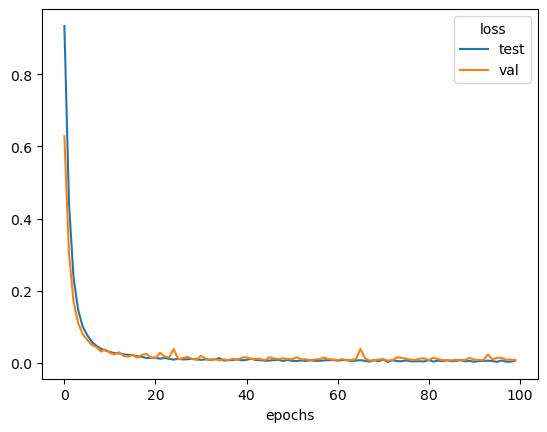

In [17]:
plt.plot(train_losses,label='test')
plt.plot(val_losses,label='val')
plt.xlabel('epochs')
plt.legend(title='loss')

# Part 6: Model Introspection [EVALUATED]
In the final section of this exercise, we want to understand the algorithm the transformer learned, by probing predictions for specific corner-cases and looking at some of its internals.


In [16]:
def highlight_cell(x,y,color):
    # Given a coordinate (x,y), highlight the corresponding cell using a colored frame in the ac
    # after having called imshow already
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False,color=color,lw=2)
    plt.gca().add_patch(rect)
    return rect

def visualize_attention_matrix(x):
  x_ = torch.tensor(x,dtype=torch.long)
  transformer(x_)
  A = transformer[1].attn_probs
  plt.imshow(A.detach().numpy(),vmin=0,cmap='winter')
  for i, x_i in enumerate(x):
    for j, x_j in enumerate(x):
      if x_i == x_j:
        highlight_cell(i,j, color='red')
  plt.colorbar()
  plt.xticks(np.arange(len(x)), x)
  plt.yticks(np.arange(len(x)), x)
  plt.xlabel('Input sequence')
  plt.ylabel('Input sequence')
  plt.title(f'Attention matrix')

#### 6.1 What is the attention layer used for?
Visualize the attention layer probabilities for some examples and highlight the cells that represent the attention onto tokens with the same token type using the given code.

- Do you have a guess on what algorithm the model is learning?
- Why is the attention layer useful?
- Do you expect it to work for shorter/longer sequences?

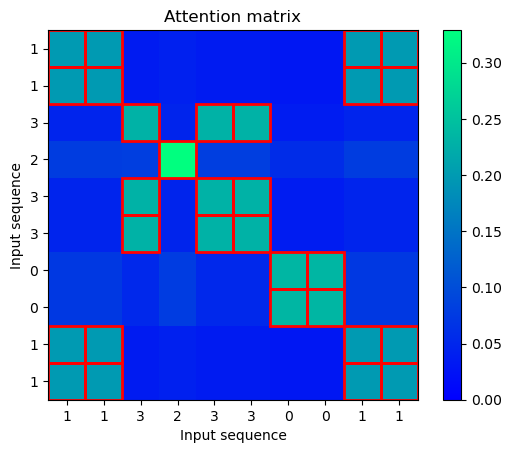

In [18]:
x = [1,1,3,2,3,3,0,0,1,1]
visualize_attention_matrix(x)

- Algorithm guess: The model clusters positions with the same token and aggregates their values, so each position “counts” how many identical tokens exist. Attention rows concentrate on same-token columns; the MLP maps that aggregated signal to a count.
- Why useful: Attention lets each position pull information from any other position with the same token type, independent of distance or order, which is perfect for histogram-style counting.
- Shorter/longer sequences: For shorter sequences it typically works well. For longer ones, attention will still highlight same-token groups, but the head was trained with `seq_len=10` and outputs `n_classes=seq_len+1`, so counts beyond that may be unreliable even if the attention pattern looks sensible.

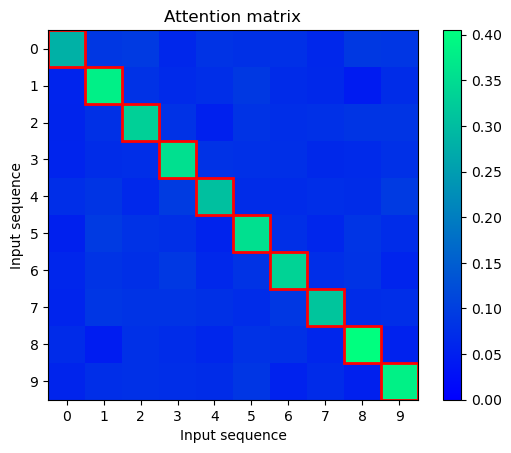

In [ ]:
# 1) All-unique tokens → attention often peaks on self
x = [0,1,2,3,4,5,6,7,8,9]
visualize_attention_matrix(x)

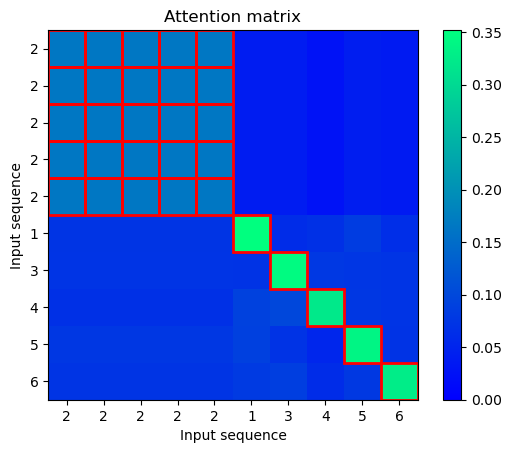

In [21]:
# 2) One token repeated in a block → strong square block
x = [2,2,2,2,2,1,3,4,5,6]
visualize_attention_matrix(x)

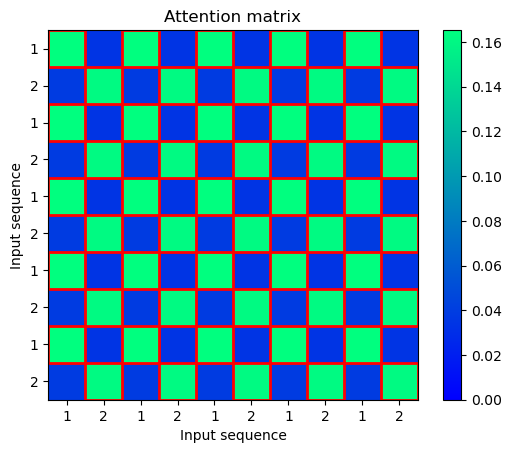

In [22]:
# 3) Alternating two tokens → checkerboard-like pattern
x = [1,2,1,2,1,2,1,2,1,2]
visualize_attention_matrix(x)

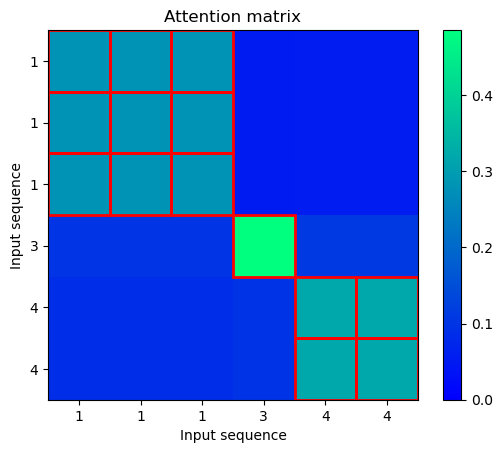

In [23]:
# 4) Shorter sequence (should still group same tokens)
x = [1,1,1,3,4,4]
visualize_attention_matrix(x)

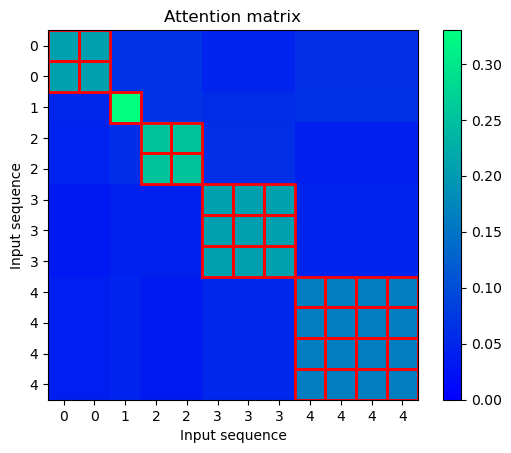

In [ ]:
def predict_sequence(x):
  pred = transformer.forward(torch.tensor(x,dtype=torch.long)).argmax(axis=-1).detach().numpy()
  y = hist(x)
  return list(pred), np.all(y == pred)

#### 6.2 Does the transformer truly generalize?

Since you now have a hypothesis of what your transformer learned, check its predictions carefully. Use the function we provide to predict a single sequence.

- Is the validation error good?
- Does it generalize to longer sequences?
- Go back to the Histogram dataset and look at how the data is generated. What sequences are unlikely to be generated. Does it generalize those low probability input samples?
- Does it generalize to unknown tokens?
- Would you have expected the answers to the above questions, given the validation error you saw?

In [25]:
def predict_sequence(x):
  pred = transformer.forward(torch.tensor(x,dtype=torch.long)).argmax(axis=-1).detach().numpy()
  y = hist(x)
  return list(pred), np.all(y == pred)

In [38]:
x = [1,1,3,2,3,3,0,0,1,1]
pred, correct = predict_sequence(x)
print("Input sequence: ", x)
print("Predicted histogram: ", pred)
print("Correct histogram:   ", hist(x))
print("Prediction correct? ", correct)

Input sequence:  [1, 1, 3, 2, 3, 3, 0, 0, 1, 1]
Predicted histogram:  [np.int64(4), np.int64(4), np.int64(3), np.int64(1), np.int64(3), np.int64(3), np.int64(2), np.int64(2), np.int64(4), np.int64(4)]
Correct histogram:    [4, 4, 3, 1, 3, 3, 2, 2, 4, 4]
Prediction correct?  True


In [ ]:
# longer
x = [0,1,2,3] * 10
pred, correct = predict_sequence(x)
print("Input sequence: ", x)
print("Predicted histogram: ", pred)
print("Correct histogram:   ", hist(x))
print("Prediction correct? ", correct)

Input sequence:  [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]
Predicted histogram:  [np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3)]
Correct histogram:    [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
Prediction correct?  False


In [29]:
# low probability, almost all same token
x = [2]*10
pred, correct = predict_sequence(x)
print("Input sequence: ", x)
print("Predicted histogram: ", pred)
print("Correct histogram:   ", hist(x))
print("Prediction correct? ", correct)

Input sequence:  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Predicted histogram:  [np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5)]
Correct histogram:    [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
Prediction correct?  False


In [44]:
# unseen tokens
x = [1,2,3,1,4,4,99]
pred, correct = predict_sequence(x)
print("Input sequence: ", x)
print("Predicted histogram: ", pred)
print("Correct histogram:   ", hist(x))
print("Prediction correct? ", correct)

IndexError: index out of range in self

- Validation error:
The validation error is low, suggesting that the model has learned the underlying rule of the dataset rather than memorizing individual sequences.
- Longer sequences:
When testing on significantly longer sequences than those seen during training (e.g. repeating [0,1,2,3] many times), the model fails to produce the correct histogram. Instead of counting occurrences, it outputs nearly constant values, indicating that it does not generalize to longer sequence lengths. This suggests the model has learned length-specific patterns rather than a true counting algorithm.
- Low-probability sequences:
For highly imbalanced inputs such as sequences containing almost a single token (e.g. [2,2,2,2,2,2,2,2,2,2]), the predictions are incorrect. This shows that the model does not generalize well to low-probability sequences that deviate strongly from the typical training distribution.
- Unseen tokens:
When providing tokens outside the training vocabulary (e.g. token 99), the model raises an index error due to the embedding lookup. This confirms that the transformer cannot handle unseen tokens and has no out-of-distribution robustness.
- Relation to validation error:
Despite a good validation error, the model does not exhibit strong algorithmic generalization. The validation metric mainly reflects performance on sequences similar to the training data, and does not guarantee generalization to longer, rarer, or out-of-distribution inputs.


# Bonus Part 7: What else?

We kept this exercise rather concise, but of course with more interesting architectures there is more to explore. You also saw that even such an "easy" task as the histogram task is not trivially solved by a simple transformer.

However, there are many ways to improve, tweaks to make, and architectural decisions to make.

If you want a full example of a transformer architecture from scratch, we recommend the following online tutorial: ["Transformer from scratch"](https://towardsdatascience.com/build-your-own-transformer-from-scratch-using-pytorch-84c850470dcb) that implements the [original transformer architecture](https://arxiv.org/pdf/1706.03762.pdf).

Also feel free to think about the following, which are active or recent research areas in machine learning:
- Where is the computational bottleneck for longer sentences? How can one circumvent it?
- How does one make positional information enter the model to identify positional information?
- What are the training strategies when I want to predict the next word only, and not a complete sequence?

Also note: It is not so difficult to use pretrained language models! Instead of training a complete model from scratch, if you want to use a model in application domains where there is true understanding of text, one can use pre-trained models available for free online (e.g. [hugging face](https://huggingface.co/)) and adapt them as you are doing in the current assignment .

# Appendix: Hugging Face LM Demo

In [60]:
from transformers import AutoTokenizer, AutoModelForCausalLM, set_seed

In [61]:
# Load tiny GPT-2 model and tokenizer
model_id = "sshleifer/tiny-gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id)
set_seed(42)

In [88]:
dummy_prompt = f"Machine learning is "  # example prompt
print(dummy_prompt)

Machine learning is 


In [89]:
# Generate from x-derived dummy text
inputs = tokenizer(dummy_prompt, return_tensors="pt")
outputs = model.generate(**inputs, max_new_tokens=20, do_sample=False)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Machine learning is  factors factors factors factors factors factors factors factors factors factors factors factors factors factors factors factors factors factors factors factors


## Bigger pretrained LM for better completions

We now switch to a slightly larger model (`distilgpt2`) and enable sampling to reduce repetition. This should produce sensible answers to simple prompts like “London is the capital of …”.

In [66]:
# Load a larger causal LM (distilgpt2)
from transformers import AutoTokenizer, AutoModelForCausalLM
model_id_big = "distilgpt2"
tokenizer_big = AutoTokenizer.from_pretrained(model_id_big)
model_big = AutoModelForCausalLM.from_pretrained(model_id_big)
# Silence pad warnings; GPT-2 family uses EOS as PAD
model_big.config.pad_token_id = tokenizer_big.eos_token_id

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [67]:
def generate_text(prompt,
                  max_new_tokens=30,
                  do_sample=True,
                  temperature=0.8,
                  top_p=0.9,
                  top_k=50,
                  no_repeat_ngram_size=3,
                  repetition_penalty=1.2):
    inputs = tokenizer_big(prompt, return_tensors="pt")
    outputs = model_big.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=do_sample,
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        no_repeat_ngram_size=no_repeat_ngram_size,
        repetition_penalty=repetition_penalty,
        pad_token_id=tokenizer_big.eos_token_id,
        eos_token_id=tokenizer_big.eos_token_id,
    )
    print(tokenizer_big.decode(outputs[0], skip_special_tokens=True))

In [91]:
prompt1 = "Machine learning is"
generate_text(prompt1)

Machine learning is now an online tool for you to learn more about your skills, build better and improve training.


- Computational bottleneck for longer sentences

The main bottleneck in transformers is the self-attention mechanism, which has quadratic complexity O(n^2) in the sequence length. This makes memory and computation grow rapidly for long sequences. Common ways to circumvent this include sparse attention, local or sliding-window attention, low-rank approximations, or linear attention variants that reduce complexity to near-linear in sequence length.

- How positional information enters the model

Since transformers are permutation-invariant, positional information must be injected explicitly. This is typically done using positional encodings, either fixed (e.g. sinusoidal encodings) or learned embeddings, which are added to token embeddings. More recent approaches include relative positional encodings or rotary embeddings, which allow the model to reason more flexibly about distances between tokens.

- Training strategies for next-word prediction

When predicting only the next word, models are trained in an autoregressive manner using a causal (masked) attention mechanism. The loss is computed only on the next-token prediction, not on the full sequence. During training, teacher forcing is commonly used, where the ground-truth prefix is provided and the model learns to predict the next token at each position.